In [514]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import train_test_split

chemin_fichier = '/Users/lucaslascaux/Desktop/docs trading/dataset.csv'

data = pd.read_csv(chemin_fichier)

data = data.assign(extended_returns_1=data['extended_returns'].shift(1),
                   extended_returns_2=data['extended_returns'].shift(2),
                   extended_returns_3=data['extended_returns'].shift(3),
                   extended_returns_4=data['extended_returns'].shift(4),
                   extended_returns_5=data['extended_returns'].shift(5))
data = data.dropna()
data.drop("symbol", axis=1, inplace=True)


data['extended_returns'] = data['extended_returns'].abs()  # Prendre les valeurs absolues de la colonne 'extended_returns'



#train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

print(data.head(0))


Empty DataFrame
Columns: [time, volatility, extended_returns, extended_returns_1, extended_returns_2, extended_returns_3, extended_returns_4, extended_returns_5]
Index: []


In [515]:
#  les quartiles
Q1 = data.quantile(0.1)
Q3 = data.quantile(0.9)

#  l'écart interquartile (IQR)
IQR = Q3 - Q1

seuil_inf = Q1 - 1.5 * IQR
seuil_sup = Q3 + 1.5 * IQR

data = data.align(seuil_inf, axis=1, copy=False)[0]

outliers = (data < seuil_inf) | (data > seuil_sup)

data = data[~outliers.any(axis=1)]

print(data.shape[0])


46123


/var/folders/53/30dg38js7lb887sbxnyyv7b00000gn/T/ipykernel_3497/863188523.py:16: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = (data < seuil_inf) | (data > seuil_sup)


In [516]:
# DataFrame avec volatilité supérieure à la médiane
data50 = data[data['volatility'] > data['volatility'].median()]

print(data50.shape[0])

23061


In [517]:
# DataFrame avec volatilité dans les 30% des plus grandes
threshold_30_percent = data['volatility'].quantile(0.7)
data30 = data[data['volatility'] >= threshold_30_percent]
print(data30.shape[0])

13837


In [518]:
# DataFrame avec volatilité dans les 10% des plus grandes
threshold_10_percent = data['volatility'].quantile(0.9)
data10 = data[data['volatility'] >= threshold_10_percent]
print(data10.shape[0])

4613


In [519]:
def test_stationarity(data):
    columns = ["volatility", "extended_returns"]
    
    for column in columns:
        selected_column = data[column]
        
        result = adfuller(selected_column)
        
        print(f"Résultats du test de Dickey-Fuller augmenté pour la colonne '{column}':")
        print(f"Statistique du test : {result[0]}")
        print(f"Valeur p : {result[1]}")
        print("Valeurs critiques :")
        for key, value in result[4].items():
            print(f"   {key}: {value}")
        
        if result[1] < 0.05:
            print("Les données sont stationnaires.")
        else:
            print("Les données ne sont pas stationnaires.")
        print("\n")

In [520]:
test_stationarity(data)

Résultats du test de Dickey-Fuller augmenté pour la colonne 'volatility':
Statistique du test : -14.35467794522247
Valeur p : 1.008065352230603e-26
Valeurs critiques :
   1%: -3.4304919629320465
   5%: -2.8616027445823486
   10%: -2.5668033968865918
Les données sont stationnaires.


Résultats du test de Dickey-Fuller augmenté pour la colonne 'extended_returns':
Statistique du test : -15.222694287761371
Valeur p : 5.457332417591618e-28
Valeurs critiques :
   1%: -3.4304919629320465
   5%: -2.8616027445823486
   10%: -2.5668033968865918
Les données sont stationnaires.




Text(0, 0.5, 'Moyenne')

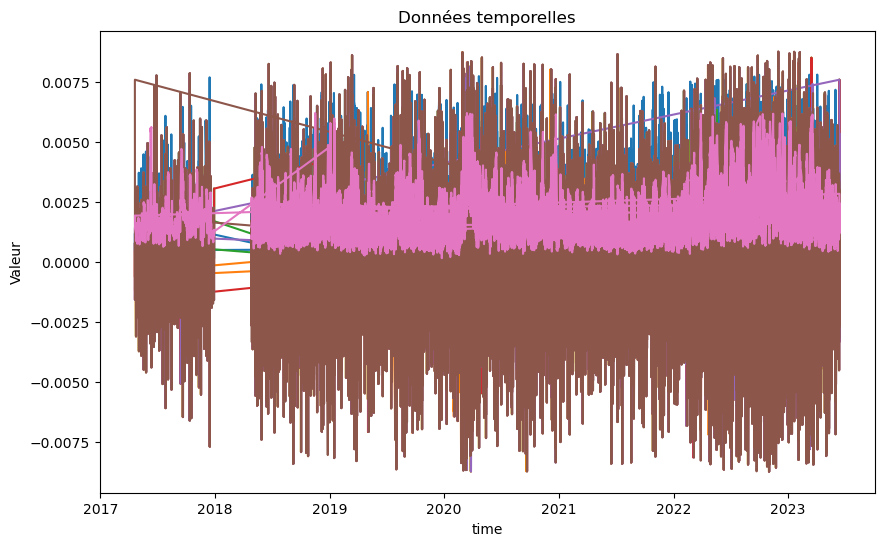

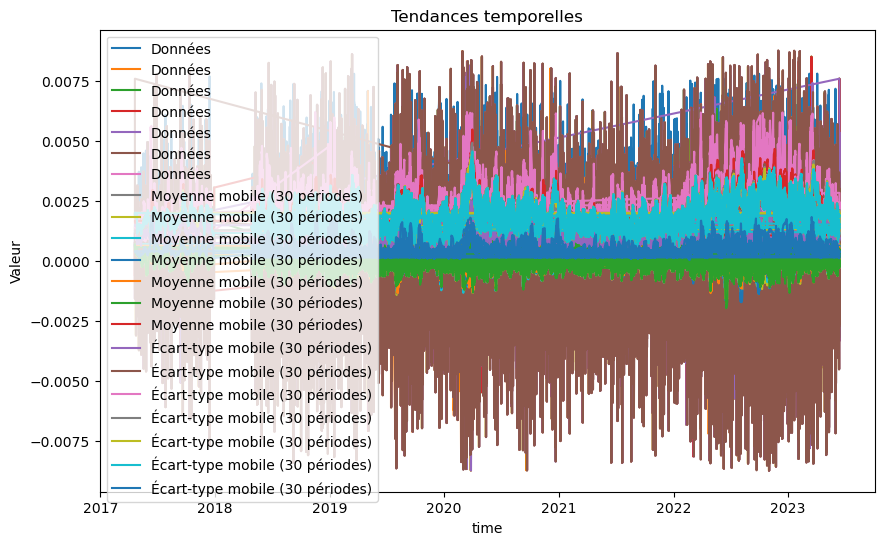

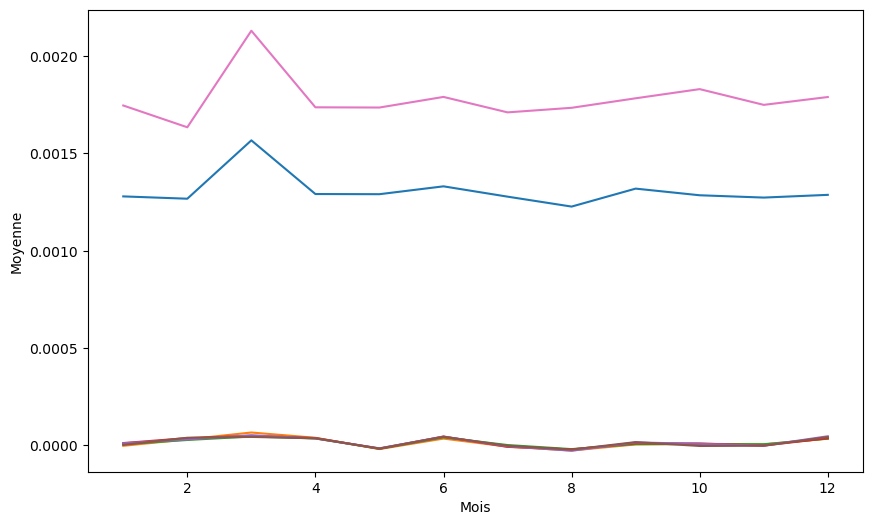

In [521]:

data['time'] = pd.to_datetime(data['time'])

data.set_index('time', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(data)
plt.xlabel('time')
plt.ylabel('Valeur')
plt.title('Données temporelles')
#plt.show()

# Analyser les tendances temporelles
rolling_mean = data.rolling(window=30).mean()  # Moyenne mobile sur une fenêtre de 30 périodes
rolling_std = data.rolling(window=30).std()  # Écart-type mobile sur une fenêtre de 30 périodes

plt.figure(figsize=(10, 6))
plt.plot(data, label='Données')
plt.plot(rolling_mean, label='Moyenne mobile (30 périodes)')
plt.plot(rolling_std, label='Écart-type mobile (30 périodes)')
plt.xlabel('time')
plt.ylabel('Valeur')
plt.title('Tendances temporelles')
plt.legend()
#plt.show()

# Analyser les motifs saisonniers
monthly_mean = data.groupby(data.index.month).mean()  # Moyenne des valeurs par mois

plt.figure(figsize=(10, 6))
plt.plot(monthly_mean)
plt.xlabel('Mois')
plt.ylabel('Moyenne')

#plt.show()



In [522]:
data.shape
data.head(0)
data_extended_returns = data['extended_returns']

In [523]:
# Grid search pour sélectionner les ordres AR et MA
best_aic = float("inf")
best_order = None

# Spécifiez les valeurs maximales pour p, d et q dans ARIMA(p, d, q)
p_max = 3
d = 1
q_max = 3

for p in range(p_max + 1):
    for q in range(q_max + 1):
        try:
            # Créez le modèle ARIMA avec les ordres actuels
            model = sm.tsa.ARIMA(data_extended_returns, order=(p, d, q))
            results = model.fit()

            # Calculez l'AIC et le BIC
            aic = results.aic
            bic = results.bic

            # Mettez à jour les meilleurs ordres si l'AIC est plus bas
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)

        except:
            continue

print("Meilleurs ordres ARIMA (p, d, q) :", best_order)
print("AIC correspondant :", best_aic)

/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

Meilleurs ordres ARIMA (p, d, q) : (2, 1, 3)
AIC correspondant : -486414.9005994133


In [524]:


p = 2
d = 1
q = 3

# Spécifiez les ordres AR, I et MA de votre modèle ARIMA
order = (p, d, q)

# Créez le modèle ARIMA avec les ordres spécifiés
model = sm.tsa.ARIMA(data_extended_returns, order=order)

# Ajustez le modèle aux données en utilisant la méthode par défaut 'css' (conditional sum of squares)
results = model.fit()

# Affichez les paramètres estimés
print("Paramètres estimés :", results.params)


/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

Paramètres estimés : ar.L1     0.384101
ar.L2    -0.698910
ma.L1    -1.219040
ma.L2     0.949020
ma.L3    -0.637309
sigma2    0.000002
dtype: float64


In [525]:

from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(data_extended_returns, test_size=0.2, shuffle=False)


order = (p, d, q)


model = sm.tsa.ARIMA(train_data, order=order)


results = model.fit()


predictions = results.get_prediction(start=test_data.index[0], end=test_data.index[-1])
predicted_values = predictions.predicted_mean

# Comparez les valeurs prédites avec les valeurs réelles dans l'ensemble de test
mse = np.mean((predicted_values - test_data) ** 2)
rmse = np.sqrt(mse)
print("RMSE (Root Mean Squared Error) sur l'ensemble de test :", rmse)


/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

RMSE (Root Mean Squared Error) sur l'ensemble de test : 0.001513477838378757


In [535]:

order = (p, d, q)

model = sm.tsa.ARIMA(data_extended_returns, order=order)


results = model.fit()

# Faites des prédictions pour d5 nouvelles observation
forecast_start = len(data_extended_returns)  # Indice de départ 
n = 5  
forecast_end = forecast_start + n  # Indice de fin 
forecast = results.get_forecast(steps=n)  # prédictions

# Valeurs prédites
predicted_values = pd.Series(forecast.predicted_mean, index=range(forecast_start, forecast_end))
confidence_intervals = pd.DataFrame(forecast.conf_int(), index=range(forecast_start, forecast_end), columns=['Lower', 'Upper'])

# Affichez
for i, val in predicted_values.items():
    print("Prédiction pour l'observation", i+1, ":")
    print("Valeur prédite :", val)
    print("Intervalle de confiance (95%) :", confidence_intervals.loc[i])
    print()




/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

Prédiction pour l'observation 46124 :
Valeur prédite : 0.001446915530658659
Intervalle de confiance (95%) : Lower   NaN
Upper   NaN
Name: 46123, dtype: float64

Prédiction pour l'observation 46125 :
Valeur prédite : 0.0014898977879865335
Intervalle de confiance (95%) : Lower   NaN
Upper   NaN
Name: 46124, dtype: float64

Prédiction pour l'observation 46126 :
Valeur prédite : 0.0014939599348663807
Intervalle de confiance (95%) : Lower   NaN
Upper   NaN
Name: 46125, dtype: float64

Prédiction pour l'observation 46127 :
Valeur prédite : 0.0014943438383256053
Intervalle de confiance (95%) : Lower   NaN
Upper   NaN
Name: 46126, dtype: float64

Prédiction pour l'observation 46128 :
Valeur prédite : 0.001494380120092455
Intervalle de confiance (95%) : Lower   NaN
Upper   NaN
Name: 46127, dtype: float64

Prédiction pour l'observation 46129 :
Valeur prédite : 0.0014943835489925447
Intervalle de confiance (95%) : Lower   NaN
Upper   NaN
Name: 46128, dtype: float64

Prédiction pour l'observation 

/Users/lucaslascaux/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [526]:
# Obtenez les résidus (différence entre les valeurs observées et les valeurs prédites)
residuals = results.resid

# Calculez les statistiques de base des résidus
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Affichez les statistiques des résidus
print("Statistiques des résidus :")
print("Moyenne des résidus :", mean_residuals)
print("Écart-type des résidus :", std_residuals)


Statistiques des résidus :
Moyenne des résidus : 2.7105346618555413e-08
Écart-type des résidus : 0.0012520311991756526


In [527]:

def calculate_correlations(data):
    data['Constant'] = 1
    y = data['extended_returns']
    correlations = pd.DataFrame(columns=['data'])

    for i in range(1, 6):
        X = data[['extended_returns_{}'.format(i), 'Constant']]
        model = sm.OLS(y, X)
        results = model.fit()
        coefficients = results.params
        correlation_regression = coefficients[0]
        correlations.loc['extended_returns_{}'.format(i), 'data'] = correlation_regression

    return correlations


correlation_data = calculate_correlations(data)
correlation_data50 = calculate_correlations(data50)
correlation_data30 = calculate_correlations(data30)
correlation_data10 = calculate_correlations(data10)




/var/folders/53/30dg38js7lb887sbxnyyv7b00000gn/T/ipykernel_3497/1009082193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Constant'] = 1


In [528]:
merged_data = pd.concat([correlation_data, correlation_data50, correlation_data30, correlation_data10], axis=1)
merged_data.columns = ['data', 'data50', 'data30', 'data10']

print(merged_data)



                        data    data50    data30    data10
extended_returns_1 -0.000709 -0.005061  -0.00285  0.006392
extended_returns_2 -0.000034 -0.005172 -0.004845  0.001685
extended_returns_3  0.001011 -0.001126  0.005162  0.019231
extended_returns_4  0.004094  0.002741 -0.000111  0.000832
extended_returns_5  -0.00394 -0.006448 -0.006388 -0.002322


In [529]:
data = data[['volatility', 'extended_returns']]
data50 = data50[['volatility', 'extended_returns']]
data30 = data30[['volatility', 'extended_returns']]
data10 = data10[['volatility', 'extended_returns']]

/var/folders/53/30dg38js7lb887sbxnyyv7b00000gn/T/ipykernel_3497/1710167957.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(range(1, len(acf_values)), acf_values[1:], use_line_collection=True)
/var/folders/53/30dg38js7lb887sbxnyyv7b00000gn/T/ipykernel_3497/1710167957.py:24: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax2.stem(range(1, len(pacf_values)), pacf_values[1:], use_line_collection=True)


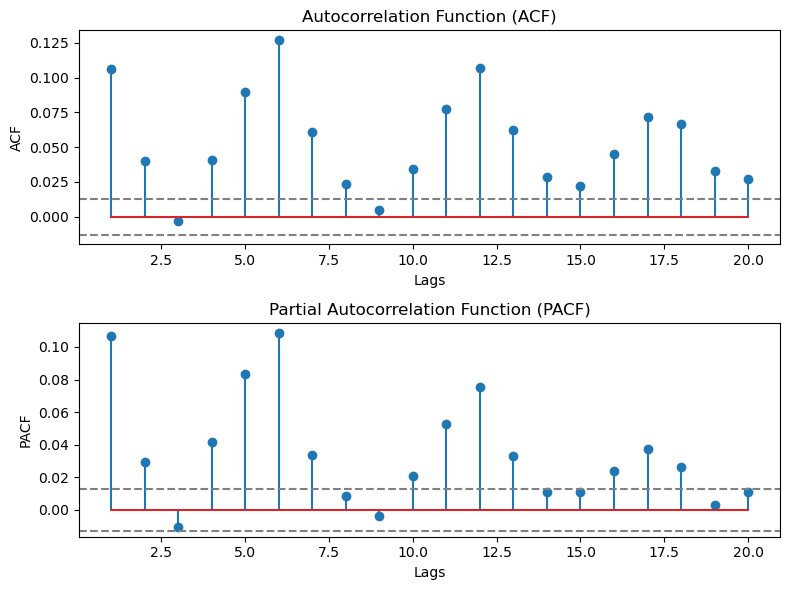

Ordre p identifié : 1
Ordre q identifié : 1


In [530]:
def identify_ARMA_orders(data, max_lags):
    column = data['extended_returns']
    
    # Calculer l'ACF et le PACF des rendements prolongés
    acf_values = acf(column, nlags=max_lags)
    pacf_values = pacf(column, nlags=max_lags)
    
    # l'ordre p du modèle AR en utilisant l'ACF
    p = np.argmax(np.abs(acf_values[1:]) > 1.96/np.sqrt(len(column))) + 1
    
    # l'ordre q du modèle MA en utilisant le PACF
    q = np.argmax(np.abs(pacf_values[1:]) > 1.96/np.sqrt(len(column))) + 1
    
    # Afficher les graphiques ACF et PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.stem(range(1, len(acf_values)), acf_values[1:], use_line_collection=True)
    ax1.axhline(y=1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax1.axhline(y=-1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax1.set_xlabel('Lags')
    ax1.set_ylabel('ACF')
    ax1.set_title('Autocorrelation Function (ACF)')
    
    ax2.stem(range(1, len(pacf_values)), pacf_values[1:], use_line_collection=True)
    ax2.axhline(y=1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax2.axhline(y=-1.96/np.sqrt(len(column)), linestyle='--', color='gray')
    ax2.set_xlabel('Lags')
    ax2.set_ylabel('PACF')
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
    
    return p, q


p, q = identify_ARMA_orders(data50, max_lags=20)
print(f"Ordre p identifié : {p}")
print(f"Ordre q identifié : {q}")



Les barres verticales sur le graphique ACF représentent les corrélations entre les valeurs actuelles et les valeurs passées à différents retards (lags).
Les barres qui s'étendent au-delà des limites de confiance supérieure et inférieure (lignes en pointillés) sont statistiquement significatives.
Si une barre dépasse les limites de confiance supérieure, cela indique une corrélation positive significative pour ce retard.
Si une barre dépasse les limites de confiance inférieure, cela indique une corrélation négative significative pour ce retard.
Les barres qui restent proches de zéro et qui sont dans les limites de confiance ne sont pas significatives.

Modèle SARIMA

In [531]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarima_model(data, order, seasonal_order):
    """
    Fonction pour ajuster un modèle SARIMA aux données temporelles.

    Arguments :
    data : Series ou array - La série temporelle à modéliser.
    order : tuple - Les ordres non saisonniers (p, d, q) du modèle SARIMA.
    seasonal_order : tuple - Les ordres saisonniers (P, D, Q, s) du modèle SARIMA.

    Retour :
    model : SARIMAXResults - Le modèle SARIMA ajusté.
    """
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    return model_fit
